<a href="https://colab.research.google.com/github/leanring-machine/yt-classifier/blob/main/notebooks/resnet50_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/yt-classifier/data.zip"

In [3]:
!pip install ResNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ResNet: filename=resnet-0.1-py3-none-any.whl size=10027 sha256=aaf9e15e7e217828eeb7c7d82750c8c88458aad28e75f0250327bb0596392cd2
  Stored in directory: /root/.cache/pip/wheels/be/62/ef/ac6244da70f4650a13902e0294d88e71cf950b4fb8dbeccb98
Successfully built ResNet


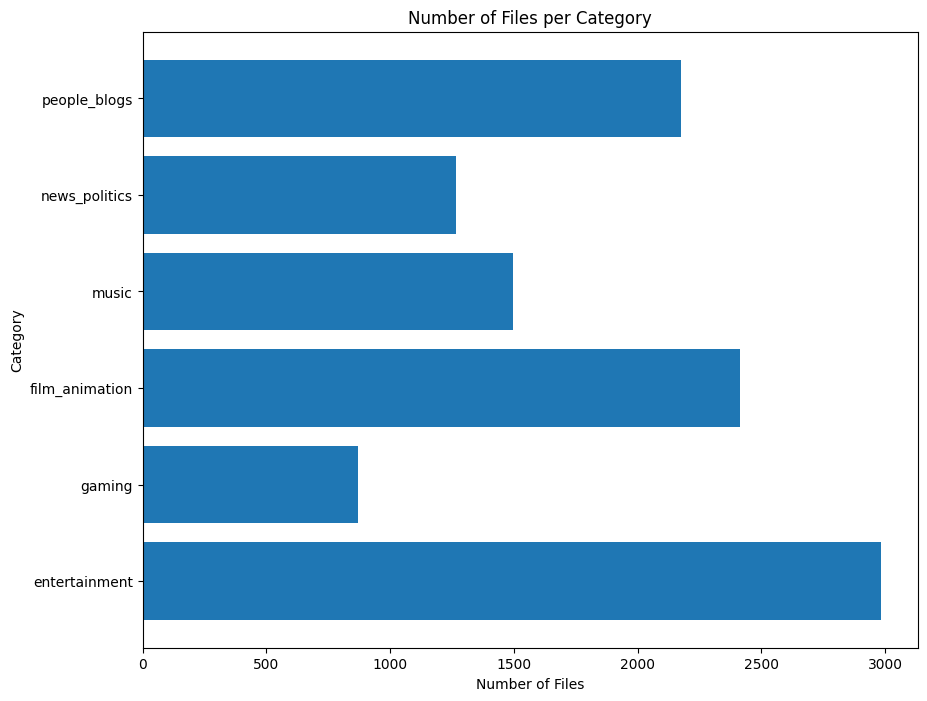

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

category_df = pd.read_csv('video_category.csv')
category_info = category_df.set_index('name')['id'].to_dict()
data_path = './thumbnail'

category_counts = {}

selected_category = [
    'entertainment', 'gaming', 'film_animation',
    'music', 'news_politics', 'people_blogs'
]

category_counts = {}
total_counts = 0

for c in selected_category:
  dir = os.path.join(data_path, c)
  category_counts[c] = len(os.listdir(dir))
  total_counts += category_counts[c]

plt.figure(figsize=(10, 8))
plt.barh(list(category_counts.keys()), list(category_counts.values()))
plt.xlabel('Number of Files')
plt.ylabel('Category')
plt.title('Number of Files per Category')
plt.show()

# ResNet

In [5]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# 데이터셋 경로 설정
base_dir = './thumbnail'

# 이미지 사이즈 설정
img_height = 180
img_width = 320

# 데이터셋 생성
data = []
labels = []

for i, class_name in enumerate(selected_category):
    class_dir = os.path.join(base_dir, class_name)
    img_paths = [os.path.join(class_dir, img_name) for img_name in os.listdir(class_dir)]
    labels.extend([i] * len(img_paths))
    data.extend(img_paths)

# 데이터셋 분할
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=1532)

In [6]:
# ResNet 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# 새로운 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(len(selected_category), activation='softmax')(x)

# 전체 모델 정의
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# 기존 레이어 동결
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


In [7]:
# 데이터 제너레이터 정의
def data_generator(images, labels, batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []
        batch_labels = []
        for index in indices:
            img_path = images[index]
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img)
            batch_images.append(img_array)
            batch_labels.append(labels[index])
        batch_images = np.array(batch_images)
        batch_labels = to_categorical(batch_labels, num_classes=len(selected_category))
        yield batch_images, batch_labels

# 모델 학습
batch_size = 32
train_generator = data_generator(train_data, train_labels, batch_size)
test_generator = data_generator(test_data, test_labels, batch_size)

steps_per_epoch = len(train_data) // batch_size
validation_steps = len(test_data) // batch_size

In [8]:
class_weight = {}
for idx, category in enumerate(selected_category):
  class_weight[idx] = (1 / category_counts[category]) * (total_counts / 2.0)

print(class_weight)

{0: 1.8791079812206573, 1: 6.440804597701149, 2: 2.3202898550724638, 3: 3.7456550802139037, 4: 4.422651933701657, 5: 2.5739549839228295}


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_callback = EarlyStopping(monitor='loss', patience=5)

history = model_resnet.fit(train_generator,
                           epochs=100,
                           steps_per_epoch=steps_per_epoch,
                           validation_data=test_generator,
                           validation_steps=validation_steps,
                           callbacks=[early_callback],
                           class_weight=class_weight
                           )

Epoch 1/100
280/280 [==============================] - 33s 76ms/step - loss: 4.0872 - accuracy: 0.4434 - val_loss: 1.2373 - val_accuracy: 0.5286
Epoch 2/100
280/280 [==============================] - 20s 72ms/step - loss: 3.3300 - accuracy: 0.5502 - val_loss: 1.2660 - val_accuracy: 0.5326
Epoch 3/100
280/280 [==============================] - 20s 72ms/step - loss: 3.0958 - accuracy: 0.5827 - val_loss: 1.2672 - val_accuracy: 0.5254
Epoch 4/100
280/280 [==============================] - 20s 73ms/step - loss: 2.8493 - accuracy: 0.6116 - val_loss: 1.2662 - val_accuracy: 0.5107
Epoch 5/100
280/280 [==============================] - 20s 72ms/step - loss: 2.7262 - accuracy: 0.6260 - val_loss: 1.2700 - val_accuracy: 0.5299
Epoch 6/100
280/280 [==============================] - 20s 72ms/step - loss: 2.5888 - accuracy: 0.6410 - val_loss: 1.2722 - val_accuracy: 0.5339
Epoch 7/100
280/280 [==============================] - 20s 73ms/step - loss: 2.3680 - accuracy: 0.6807 - val_loss: 1.3164 - val_ac

In [10]:
# 모델 평가
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

70/70 [==============================] - 4s 60ms/step - loss: 3.8398 - accuracy: 0.5424
Test Loss: 3.839801549911499
Test Accuracy: 0.5424107313156128


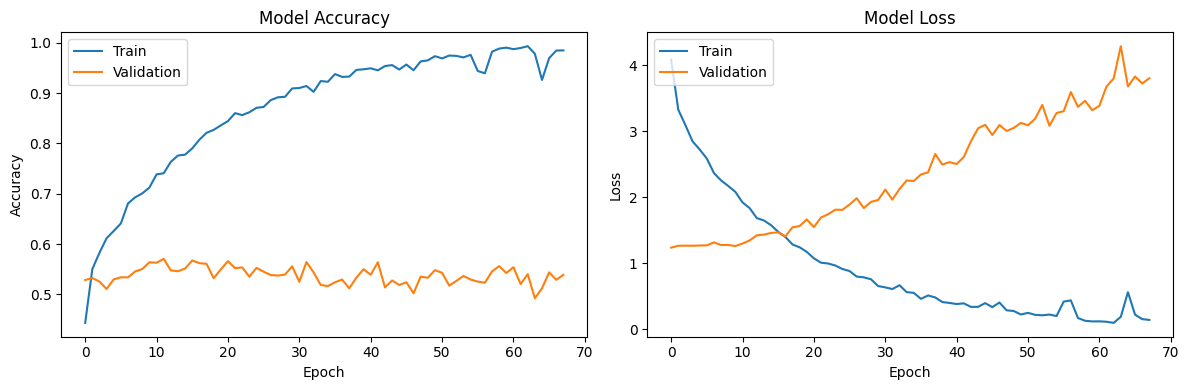

In [11]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    # 정확도 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 손실 함수 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화
plot_training_history(history)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_height = 180
img_width = 320


# 예측 결과 시각화 및 분석
def predict_image(model, image_path, class_names):
    img_path = image_path
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)
    confidence = prediction[0][predicted_label] * 100

    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted: {} ({:.2f}%)".format(class_names[predicted_label], confidence))
    plt.show()

1/1 [==============================] - 0s 25ms/step


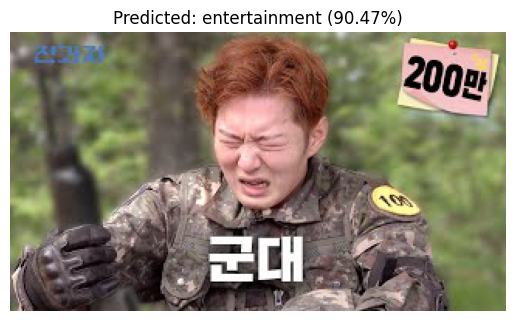

In [21]:
import requests

vid = 'sqOwr-yoCeI'
thumbnail_url = f'https://img.youtube.com/vi/{vid}/mqdefault.jpg'
response = requests.get(thumbnail_url)
with open(f'{vid}.jpg', 'wb') as f:
  f.write(response.content)
predict_image(model_resnet, f'{vid}.jpg', selected_category)

In [14]:
model_resnet.save('resnet_train.keras')
!cp resnet_train.keras drive/MyDrive/resnet_train.keras

# Xception

In [15]:
from tensorflow.keras.applications.xception import Xception


base_xmodel = Xception(include_top=False, input_shape=(img_height, img_width, 3))

# 새로운 레이어 추가
x = base_xmodel.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
xpredictions = Dense(len(selected_category), activation='softmax')(x)

# 전체 모델 정의
model_xception = Model(inputs=base_xmodel.input, outputs=xpredictions)

# 기존 레이어 동결
for layer in base_xmodel.layers:
    layer.trainable = False

# 모델 컴파일
model_xception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


83683744/83683744 [==============================] - 5s 0us/step


In [16]:
xhistory = model_xception.fit(train_generator,
                           epochs=100,
                           steps_per_epoch=steps_per_epoch,
                           validation_data=test_generator,
                           validation_steps=validation_steps,
                           callbacks=[early_callback],
                           class_weight=class_weight
                           )

Epoch 1/100
280/280 [==============================] - 25s 77ms/step - loss: 6.2670 - accuracy: 0.1924 - val_loss: 1.7853 - val_accuracy: 0.1906
Epoch 2/100
280/280 [==============================] - 19s 69ms/step - loss: 5.2502 - accuracy: 0.2152 - val_loss: 1.7685 - val_accuracy: 0.2201
Epoch 3/100
280/280 [==============================] - 19s 69ms/step - loss: 5.1360 - accuracy: 0.2417 - val_loss: 1.7289 - val_accuracy: 0.2406
Epoch 4/100
280/280 [==============================] - 20s 70ms/step - loss: 4.9694 - accuracy: 0.2763 - val_loss: 1.7362 - val_accuracy: 0.2549
Epoch 5/100
280/280 [==============================] - 20s 71ms/step - loss: 4.9092 - accuracy: 0.2823 - val_loss: 1.6614 - val_accuracy: 0.2879
Epoch 6/100
280/280 [==============================] - 19s 69ms/step - loss: 4.7547 - accuracy: 0.2919 - val_loss: 1.6105 - val_accuracy: 0.3205
Epoch 7/100
280/280 [==============================] - 19s 69ms/step - loss: 4.6186 - accuracy: 0.3089 - val_loss: 1.6474 - val_ac

In [17]:
# 모델 평가
test_loss, test_accuracy = model_xception.evaluate(test_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

70/70 [==============================] - 4s 59ms/step - loss: 1.6652 - accuracy: 0.3683
Test Loss: 1.6651884317398071
Test Accuracy: 0.3683035671710968


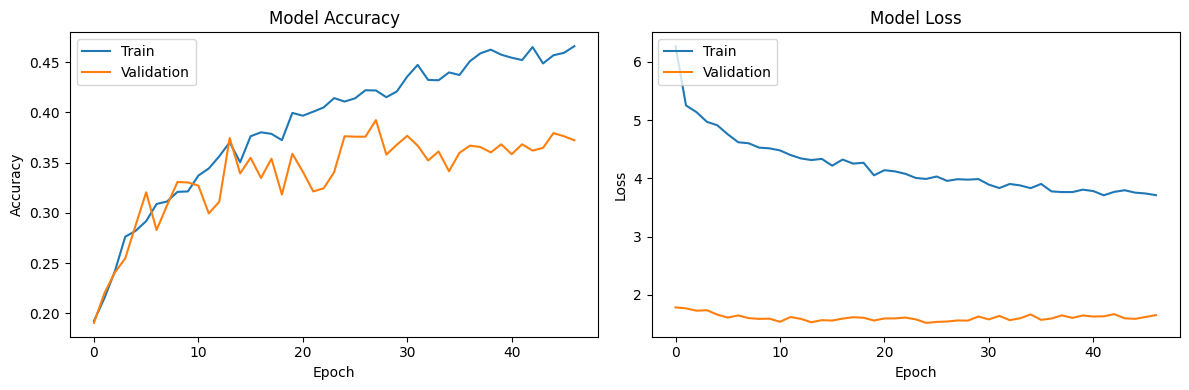

In [18]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    # 정확도 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 손실 함수 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화
plot_training_history(xhistory)


1/1 [==============================] - 0s 23ms/step


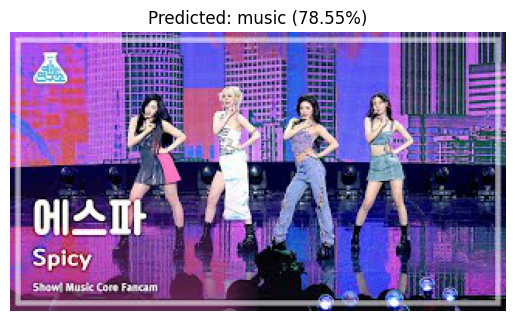

In [34]:
import requests

vid = '3pmaDofPC4c'
thumbnail_url = f'https://img.youtube.com/vi/{vid}/mqdefault.jpg'
response = requests.get(thumbnail_url)
with open(f'{vid}.jpg', 'wb') as f:
  f.write(response.content)
predict_image(model_xception, f'{vid}.jpg', selected_category)

1/1 [==============================] - 0s 23ms/step


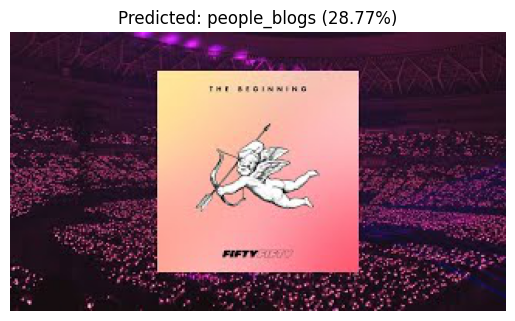

In [24]:
vid = 'NgBi-wr7lQ0'
thumbnail_url = f'https://img.youtube.com/vi/{vid}/mqdefault.jpg'
response = requests.get(thumbnail_url)
with open(f'{vid}.jpg', 'wb') as f:
  f.write(response.content)
predict_image(model_xception, f'{vid}.jpg', selected_category)

In [20]:
model_xception.save('xception.keras')
!cp xception.keras drive/MyDrive/xception.keras